# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [206]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)


(891221, 85)
(85, 4)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

# In this code block we will create a new column in feat_info that will contain
#   the processed missing values
# This is crude but it works and since there are only 85 rows it is fast. 
feat_info['missing'] = feat_info['missing_or_unknown'].copy()
characters = ['', 'X', 'XX']

# iterate through feat_info row by row
for idx in range(feat_info.shape[0]):
    
    # create a list from 'missing' at row idx and remove the brackets
    temp_list  = feat_info.iloc[idx]['missing'][1:-1].split(sep=',')                                
    temp_list2 = []                   
    for c in temp_list:               # need to iterate through the original list 
        if c in characters:           # if 'X' or 'XX', add to new list as is
            temp_list2.append(c)
        else:                         # if not, it's a number and needs
            temp_list2.append(int(c)) #    to be converted to int before added to new list
    temp_list = temp_list2
    
    feat_info.at[idx, 'missing'] = temp_list

#feat_info

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [9]:
# now we need to apply this to the data set

# algo
#   for each col in azdias:
#      look for entries corresponding to feat_col.at[col, missing]
#      if there are any, replace them with nan

azdias_cols = azdias.columns

for col in azdias_cols:
    temp_feature = azdias[col].copy()
    temp_missing = feat_info.loc[feat_info['attribute'] == col]['missing'].array
    temp_feature[temp_feature.isin(temp_missing[0])] = np.nan
    azdias[col] = temp_feature

azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,NaN,4.0,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

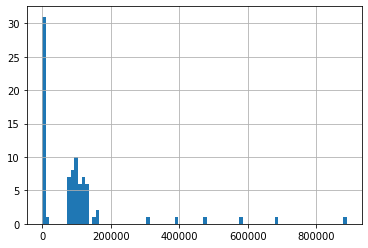

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_col_data = {}

for col in azdias.columns:        
    missing_col_data[col] = azdias[col].isnull().sum() 

missing_features = pd.DataFrame.from_dict(missing_col_data, orient='index')
missing_features.rename(columns={0:'# NaNs'}, inplace=True)
missing_features.sort_values(by='# NaNs', ascending=False, inplace=True)
missing_features['% NaNs'] = 100 * missing_features['# NaNs'] / azdias.shape[0]

missing_features['# NaNs'].hist(bins=85)

In [12]:
print(missing_features.to_string())

                       # NaNs     % NaNs
TITEL_KZ               889061  99.757636
AGER_TYP               685843  76.955435
KK_KUNDENTYP           584612  65.596749
KBA05_BAUMAX           476524  53.468668
GEBURTSJAHR            392318  44.020282
ALTER_HH               310267  34.813699
KKK                    158064  17.735668
REGIOTYP               158064  17.735668
W_KEIT_KIND_HH         147988  16.605084
KBA05_ANTG1            133324  14.959701
KBA05_ANTG2            133324  14.959701
KBA05_ANTG3            133324  14.959701
KBA05_ANTG4            133324  14.959701
KBA05_GBZ              133324  14.959701
MOBI_REGIO             133324  14.959701
PLZ8_ANTG3             116515  13.073637
PLZ8_ANTG2             116515  13.073637
PLZ8_GBZ               116515  13.073637
PLZ8_HHZ               116515  13.073637
PLZ8_ANTG1             116515  13.073637
PLZ8_BAUMAX            116515  13.073637
PLZ8_ANTG4             116515  13.073637
VERS_TYP               111196  12.476816
HEALTH_TYP      

In [13]:
# Investigate patterns in the amount of missing data in each column.

# It appears that the outliers start with ~300,000 NaNs. There appear to be 6 features that are 
#    missing more than 300,000, or approximately 1/3 of the data. 

                            # NaNs     % NaNs
#    TITEL_KZ               889061  99.757636
#    AGER_TYP               685843  76.955435
#    KK_KUNDENTYP           584612  65.596749
#    KBA05_BAUMAX           476524  53.468668
#    GEBURTSJAHR            392318  44.020282
#    ALTER_HH               310267  34.813699

# There are several features that have the same number of NaNs. This could
#   indicate duplicated values. The features are:

#    KBA05_ANTG1            133324  14.959701
#    KBA05_ANTG2            133324  14.959701
#    KBA05_ANTG3            133324  14.959701
#    KBA05_ANTG4            133324  14.959701
#    KBA05_GBZ              133324  14.959701
#    MOBI_REGIO             133324  14.959701

#    PLZ8_ANTG3             116515  13.073637
#    PLZ8_ANTG2             116515  13.073637
#    PLZ8_GBZ               116515  13.073637
#    PLZ8_HHZ               116515  13.073637
#    PLZ8_ANTG1             116515  13.073637
#    PLZ8_BAUMAX            116515  13.073637
#    PLZ8_ANTG4             116515  13.073637

#    VERS_TYP               111196  12.476816
#    HEALTH_TYP             111196  12.476816
#    SHOPPER_TYP            111196  12.476816
    
#    CAMEO_INTL_2015         99352  11.147852
#    CAMEO_DEU_2015          99352  11.147852
#    CAMEO_DEUG_2015         99352  11.147852
    
#    ARBEIT                  97375  10.926022
#    RELAT_AB                97375  10.926022
    
#    INNENSTADT              93740  10.518154
#    EWDICHTE                93740  10.518154
#    BALLRAUM                93740  10.51815
    
#    WOHNLAGE                93148  10.451729
#    OST_WEST_KZ             93148  10.451729
#    MIN_GEBAEUDEJAHR        93148  10.451729
#    GEBAEUDETYP             93148  10.451729
    
#    LP_FAMILIE_FEIN         77792   8.728699
#    LP_FAMILIE_GROB         77792   8.728699
    
#    WOHNDAUER_2008          73499   8.247000
#    SOHO_KZ                 73499   8.247000
#    ANZ_TITEL               73499   8.247000
#    ANZ_PERSONEN            73499   8.247000
    
#    GFK_URLAUBERTYP          4854   0.544646
#    CJT_GESAMTTYP            4854   0.544646
#    LP_STATUS_FEIN           4854   0.544646
#    LP_STATUS_GROB           4854   0.544646
#    RETOURTYP_BK_S           4854   0.544646
#    ONLINE_AFFINITAET        4854   0.544646

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# We will use 33% NaNs as a threshold
col_threshold = 33
features_to_drop = missing_features[missing_features['% NaNs'] > col_threshold].index.tolist()
azdias.drop(features_to_drop, axis=1, inplace=True)
azdias.head()

# This works. rerun the entire book up to this point

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

>I noted two observations:<br>
>>1. There were 6 features in which over 1/3 of the feature values were missing. These features were removed.<br>
>>2. There are several groups of features that have the same numbers of missing data. They are listed in the code block above. It is possible that these are duplicate features.<br>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?


# In this code block we will create a new column in azdias that will contain
#   the number of missing values 
azdias['# NaNs'] = azdias.isnull().sum(axis=1)
azdias['% NaNs'] = 100 * azdias['# NaNs'] / (azdias.shape[1] - 1)
azdias_sorted = azdias.sort_values(by='# NaNs', axis=0, ascending=False)
azdias_sorted

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,# NaNs,% NaNs
732775,3.0,2,NaN,3,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,62.025316
643174,3.0,1,NaN,2,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,62.025316
472919,1.0,1,NaN,5,1,5,2,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,60.759494
345274,1.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671
299868,2.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671
582092,1.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671
681255,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671
818343,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671
582109,1.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671
439981,2.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,59.493671


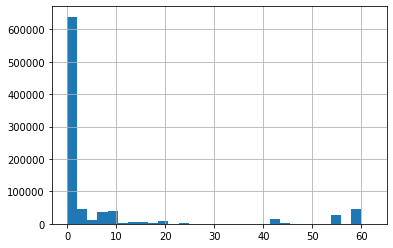

In [16]:
# Let's look at the distribution
azdias_sorted['% NaNs'].hist(bins=30)

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# from the histogram we can see that there are two sets of data pertaining to 
#   NaNs. The groups are split around 5% missing data. We will split accordingly.
#   Note that most of the data has ver little NaNs.

row_nan_threshold = 5
azdias_lower = azdias[azdias['% NaNs'] < row_nan_threshold]
azdias_upper = azdias[azdias['% NaNs'] > row_nan_threshold]

print (azdias_lower.shape, azdias_lower['% NaNs'].max())
print (azdias_upper.shape, azdias_upper['% NaNs'].min())

(684502, 81) 3.7974683544303796
(206719, 81) 5.063291139240507


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# we need to identify some columns in each data set that does not have any NaNs.
# there are 24 features that do not have NaNs in either data set.

azdias_upper_notna = azdias_upper[azdias_upper.columns[~azdias_upper.isnull().any()]].columns.values.tolist()
azdias_lower_notna = azdias_lower[azdias_lower.columns[~azdias_lower.isnull().any()]].columns.values.tolist()

azdias_notna = list(set(azdias_upper_notna) & set(azdias_lower_notna)) 
azdias_notna.remove('# NaNs')
azdias_notna.remove('% NaNs')
azdias_lower.drop('# NaNs', axis=1, inplace=True)
azdias_lower.drop('% NaNs', axis=1, inplace=True)

print(azdias_notna[:5])
print(len(azdias_notna))

['SEMIO_REL', 'FINANZ_VORSORGER', 'FINANZ_HAUSBAUER', 'SEMIO_KRIT', 'FINANZ_MINIMALIST']
24


C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


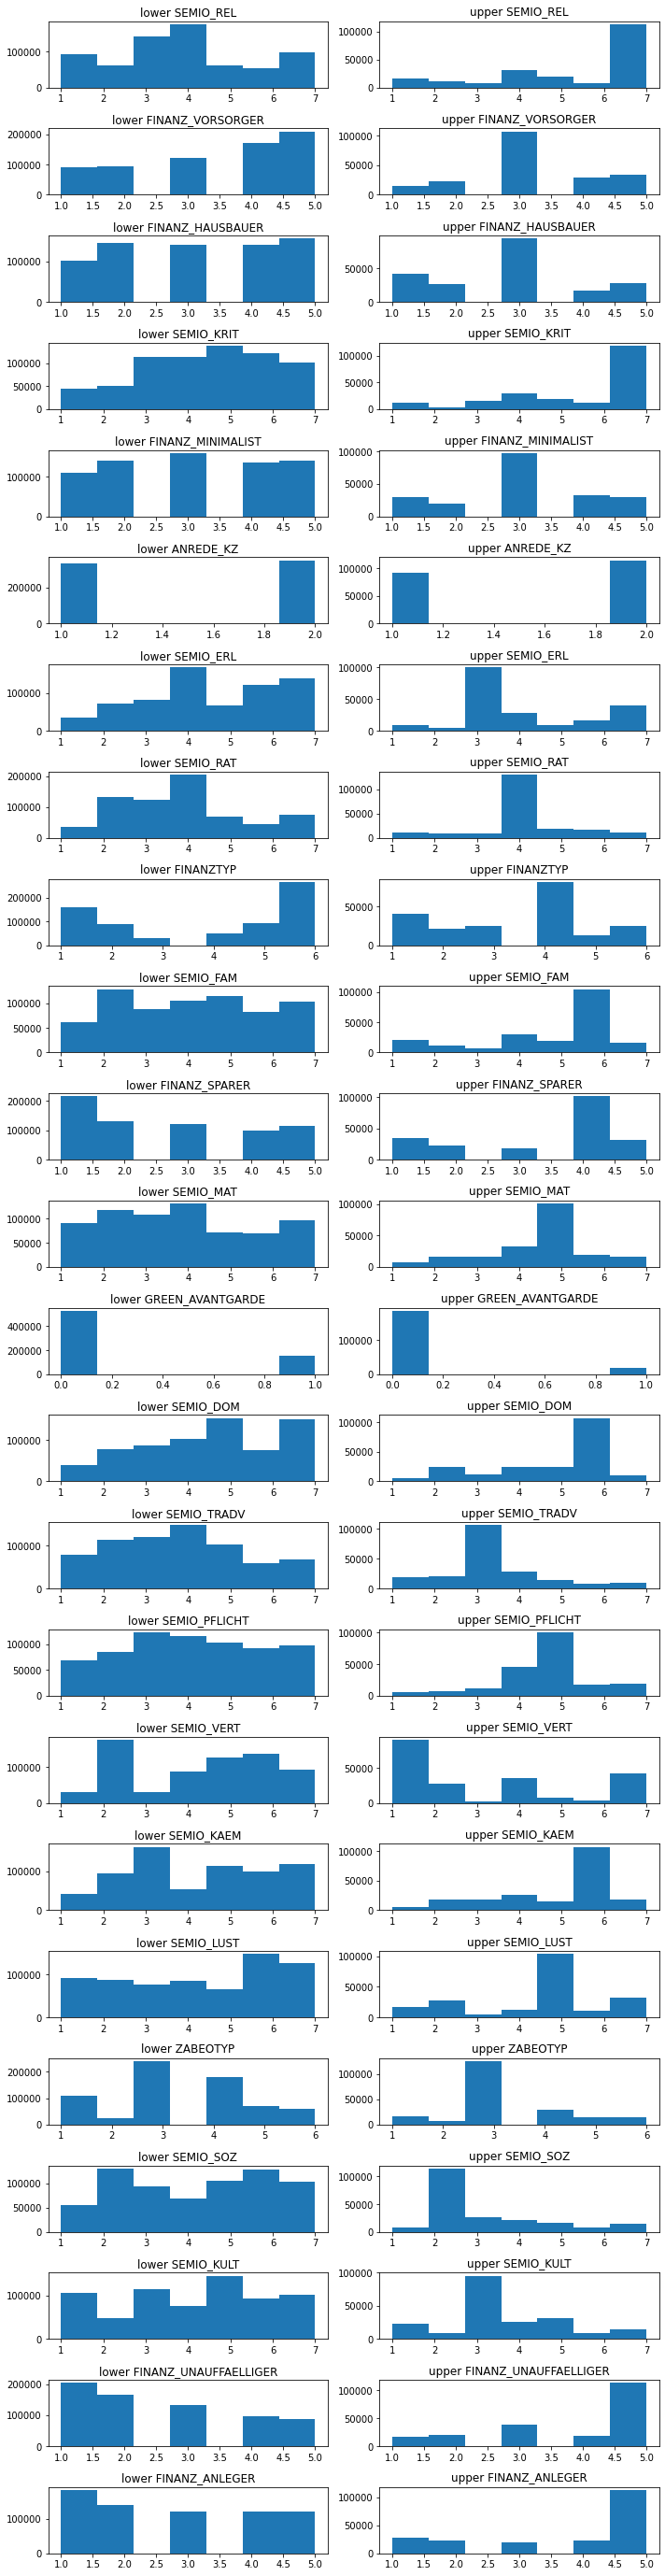

In [19]:
# Lets grab some of the features that have zero NaNs for the two data sets 
#   and plot some histograms to compare distributions

num_features_to_compare = 24
azdias_notna_top = azdias_notna[:num_features_to_compare]

# create a dataset to use for the histograms
# we'll leave off the x and y values
data   = []
x_axes = []
y_axes = []
titles = []
for idx in range(len(azdias_notna_top)):
    feature = azdias_notna_top[idx]
    data.append(azdias_lower[feature].tolist())
    data.append(azdias_upper[feature].tolist())
    titles.append('lower '+feature)
    titles.append('upper '+feature)  

fig,a = plt.subplots(num_features_to_compare,2,figsize=(10,1.6*num_features_to_compare))
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(data[idx], bins=7)
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
plt.tight_layout()


#### Discussion 1.1.3: Assess Missing Data in Each Row

>Observations of the row data<br>
>>I chose a threshold of 5% NaN to split the "lower" rows and the "upper" ones in the *azdias* data set. The max NaN percentage for the "lower" rows was ~3.8% and the min for the "upper" rows was ~5.1%. This seems like a resonable threshold.<br><br>
>>There are 24 features that have no NaNs.<br><br>
>>The distributions for each of these 24 features in the "lower" and "upper" rows do not match with the exception of two: Green_AVANTGARDE and ANREDE_KZ<br><br>
>>From this point on we will use the data set *azdias_lower*

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# we need to get a view of feat_info without the features that we dropped earlier
feat_info_reduced = feat_info.copy()
feat_info_reduced = feat_info_reduced[~feat_info_reduced['attribute'].isin(features_to_drop)]
feat_info_reduced.head()

,attribute,information_level,type,missing_or_unknown,missing
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]


In [21]:
# How many features are there of each data type?
feat_info_reduced.groupby(['type']).agg('count')

,attribute,information_level,missing_or_unknown,missing
type,,,,
categorical,18,18,18,18
mixed,6,6,6,6
numeric,6,6,6,6
ordinal,49,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info_reduced[feat_info['type']=='categorical']['attribute'].tolist()

for feature in categorical: 
    values = azdias_lower[feature].unique()
    print(feature, values)

# Binary numerical    ANREDE_KZ
#                     GREEN_AVANTGARDE
#                     SOHO_KZ 
#                     VERS_TYP
#
# The rest are either binary string or multi-level. All of these need to be re-encoded.
# Two have NaNs. I think I will just encode the NaN as a seperate feature rather than
#   try to derive its value. This should work for categorical features. 


C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


ANREDE_KZ [2 1]
CJT_GESAMTTYP [5. 3. 2. 4. 1. 6.]
FINANZTYP [1 5 2 4 6 3]
GFK_URLAUBERTYP [10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  6.  2.]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [3. 1. 5. 2. 4.]
LP_STATUS_FEIN [ 2.  3.  4.  1. 10.  8.  9.  5.  6.  7.]
LP_STATUS_GROB [1. 2. 5. 4. 3.]
NATIONALITAET_KZ [1. 2. 3.]
SHOPPER_TYP [3. 2. 0. 1.]
SOHO_KZ [1. 0.]
VERS_TYP [2. 1.]
ZABEOTYP [5 4 1 6 3 2]
GEBAEUDETYP [8. 1. 3. 6. 2. 4. 5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '6' '2' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015 ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '2A' '1B'
 '8B' '7A' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '5C' '9C'
 '7D' '5E' '1D' '8D' '6C' '5B' '7C' '4D' '3A' '2B' '7E' '3B' '6F' nan '5F'
 '1C' '6A']


In [23]:
azdias_lower.columns.size

79

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

# We'll loop through the categorical features and one encode some of them
# We will make a copy of azdias_lower and use it

azdias_preprocessed = azdias_lower.copy()

for feature in categorical: 
    values = azdias_preprocessed[feature].unique()
    if (values.size > 2) | (type(values[0]) == str):                          # if string or multi-level
        X = pd.get_dummies(azdias_preprocessed[feature], prefix=[feature])    # one hot encode
        azdias_preprocessed[X.columns] = X                                    # concatenate
        azdias_preprocessed.drop(feature, axis=1, inplace=True)               # drop the original feature
        
print(azdias_preprocessed.columns.size)
print(azdias_preprocessed.columns.tolist())

# There were 79 columns before one hot encoding the categorical features. 

195
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARB

#### Discussion 1.2.1: Re-Encode Categorical Features

>Observations<br>
>>Most of the categorical features required one hot encoding. There were a few (listed in one of the above code blocks) that did not. <br><br>
>>I chose to one hoe encode any categorical feature that had more than 2 values (multi-level) or contained strings.<br><br>
>>Further, I chose to encode NaNs as a seperate categorical feature rather than assign an existing category to them.<br><br>
>>The number of features increased from 79 to 195.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Let's look at the mixed feature types
mixed = feat_info_reduced[feat_info['type']=='mixed']['attribute'].tolist()

for feature in mixed: 
    values = azdias_lower[feature].unique()
    print(feature, values)
    
# from this we can see that some of the features have NaNs.     

LP_LEBENSPHASE_FEIN [21.  3. 32.  8.  2.  5. 10.  4.  6. 20.  1. 25. 13. 18. 31. 38. 30.  7.
 22. 14. 35. 29. 24. 37. 26. 12. 39. 27. 36.  9. 34. 33. 15. 11. 40. 16.
 19. 23. 28. 17. nan]
LP_LEBENSPHASE_GROB [ 6.  1. 10.  2.  3.  5.  7. 12.  9.  4. 11.  8. nan]
PRAEGENDE_JUGENDJAHRE [14. 15.  8.  3. 10. 11.  9.  6.  5.  4. nan  2.  1. 12. 13.  7.]
WOHNLAGE [4. 2. 3. 7. 5. 1. 8. 0.]
CAMEO_INTL_2015 ['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '12' '41' '25' '23'
 '31' '52' '35' '45' '33' '44' '32' nan]
PLZ8_BAUMAX [1. 2. 4. 5. 3.]


C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# The range for this is [14. 15.  8.  3. 10. 11.  9.  6.  5.  4. nan  2.  1. 12. 13.  7.]
# We have to review the Data_Dictionary to make sense of it.
# -1 and 0 are unknown. We will set the NaNs we created earlier to 0.  
# The coding for "movement" and "decade" that I will use
#    movement: unknown=0, Mainstream=1, Avantguard=2 
#    decade: unknown=0, 40s=1, 50s=2, 60s=3, 70s=4, 80s=5, 90s=6
#    PRAEGENDE_JUGENDJAHRE -> [movement, decade]

# We cannot completely seperate E from W, so we will not address it. 

PRAEGENDE_JUGENDJAHRE_map = {0:[0,0],   1:[1,1], 2:[2,1],
                             3:[1,2],   4:[2,2], 5:[1,3],
                             6:[2,3],   7:[2,3], 8:[1,4],
                             9:[2,4],  10:[1,5],11:[2,5],
                             12:[1,5], 13:[2,5],14:[1,6],
                             15:[2,6]
                            }

# We will need to address the NaNs. Lets set them to 0
azdias_preprocessed['PRAEGENDE_JUGENDJAHRE'].fillna(value=0, inplace=True)

# We can create two new features and map them using PRAEGENDE_JUGENDJAHRE_map
azdias_preprocessed['PRAEGENDE_JUGENDJAHRE_movement'] = \
     azdias_preprocessed['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_map).map(lambda x: x[0])
azdias_preprocessed['PRAEGENDE_JUGENDJAHRE_decade'] = \
     azdias_preprocessed['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_map).map(lambda x: x[1])

# Since we are not able to completely split E and W, we will keep 'PRAEGENDE_JUGENDJAHRE'
#   and not remove it

azdias_preprocessed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['CAMEO_DEU_2015']_8B,['CAMEO_DEU_2015']_8C,['CAMEO_DEU_2015']_8D,['CAMEO_DEU_2015']_9A,['CAMEO_DEU_2015']_9B,['CAMEO_DEU_2015']_9C,['CAMEO_DEU_2015']_9D,['CAMEO_DEU_2015']_9E,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0,1,6
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,2,6
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,1,4
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,1,0,0,0,0,0,0,1,2
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,0,1,5


In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# The range for this is ['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '12' 
#      '41' '25' '23' '31' '52' '35' '45' '33' '44' '32' nan]
# We have to review the Data_Dictionary to make sense of it.
# -1 is unknown. We will set the NaNs we created earlier to -1.  
# The coding for "wealth" and "life stage from the dictionary is
#    houshold: unknown=-x1 and XX, Wealthy=1x, Properous=2x, Confortable=3x, Less Affluent=4x, Poorer=5x 
#    life stage: unknown=x0, Pre-Fam=x1, Young=x2, Family=x3, Old Family=x4, Elders=x5 
# 
# We can simply split the 10's from the 1's for the new features.

# We need to address the NaNs. Let's set them to a value that we can split in which
#   both the ten's and one's are not used. We'll use 99.
azdias_preprocessed['CAMEO_INTL_2015'].fillna(value=99, inplace=True)

# We now need to split the values. One way to do this is to convert the series in to strings
#   and use .str to slice them. Then we turn them back into ints. 
azdias_preprocessed['CAMEO_INTL_2015']            = azdias_preprocessed['CAMEO_INTL_2015'].astype(str)
azdias_preprocessed['CAMEO_INTL_2015_wealth']     = azdias_preprocessed['CAMEO_INTL_2015'].str[0].astype(int)
azdias_preprocessed['CAMEO_INTL_2015_lifestage']  = azdias_preprocessed['CAMEO_INTL_2015'].str[1].astype(int)
azdias_preprocessed.drop('CAMEO_INTL_2015', axis=1, inplace=True)

azdias_preprocessed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['CAMEO_DEU_2015']_8D,['CAMEO_DEU_2015']_9A,['CAMEO_DEU_2015']_9B,['CAMEO_DEU_2015']_9C,['CAMEO_DEU_2015']_9D,['CAMEO_DEU_2015']_9E,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,6,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,2,6,2,4
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,4,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,2,5,4
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,1,5,2,2


In [1]:
# We will address the other mixed types
#
# LP_LEBENSPHASE_FEIN [21.  3. 32.  8.  2.  5. 10.  4.  6. 20.  1. 25. 13. 18. 31. 38. 30.  7.
#     22. 14. 35. 29. 24. 37. 26. 12. 39. 27. 36.  9. 34. 33. 15. 11. 40. 16.
#     19. 23. 28. 17. nan]
# LP_LEBENSPHASE_GROB [ 6.  1. 10.  2.  3.  5.  7. 12.  9.  4. 11.  8. nan]
# WOHNLAGE [4. 2. 3. 7. 5. 1. 8. 0.]
# PLZ8_BAUMAX [1. 2. 4. 5. 3.]

# I'm not seeing any obvious ways to derive additional features from these. Some of them
#   have NaNs will be addressed later. 

#### Discussion 1.2.2: Engineer Mixed-Type Features

>Observations
>>PRAEGENDE_JUGENDJAHRE contains three types of information. I was able to extract two of them into seperate features using a code book (a map). Since I could not completely decompose PRAEGENDE_JUGENDJAHRE, I am keeping it as a feature. NaNs are set to 0 for the two new features.  <br><br>
>>CAMEO_INTL_2015 contains two types of information. I was able to extract them both by splitting the tens from the ones. Since I was able to completely decomponse CAMEO_INTL_2015, it is no longer needed. NaNs for the two new features are set to 9.<br><br>
>>The remaining mixed features are not easily decomposed and I have left them as is. I dont' see a reason to remove them, so they will remain. NaNs will be dealt with later.<br><br>
>>At this point, we have 198 features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Based on the information in 1.2.33, I need to drop PRAEGENDE_JUGENDJAHRE.
azdias_preprocessed.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# At this point, we have 197 features. 

azdias_preprocessed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['CAMEO_DEU_2015']_8D,['CAMEO_DEU_2015']_9A,['CAMEO_DEU_2015']_9B,['CAMEO_DEU_2015']_9C,['CAMEO_DEU_2015']_9D,['CAMEO_DEU_2015']_9E,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,6,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,2,6,2,4
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,4,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,2,5,4
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,1,5,2,2


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
# For this step, I have to take all the code from earlier and incorporate it into this function.  

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:  Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    cleaned_df                   = df.copy()
    feature_info_raw             = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feature_info_clean           = update_missing_feature_list(feature_info_raw)
    cleaned_df                   = replace_missing_with_nan(cleaned_df, feature_info_clean)
    
    # remove selected columns and rows, ...
    cleaned_df, dropped_features = drop_columns_from_data(cleaned_df)
    cleaned_df                   = drop_rows_from_data(cleaned_df)
    
    # select, re-encode, and engineer column values.
    cleaned_df                    = re_encode_categorical_features(cleaned_df, feature_info_clean, dropped_features)
    cleaned_df                    = re_encode_mixed_features(cleaned_df, feature_info_clean, dropped_features)
    
    # Return the cleaned dataframe.
    return cleaned_df

In [33]:
def update_missing_feature_list(feature_df):
    """
    Perform updating of Feature Information 'missing_or_unknown' so that it can be more easily used.
    Remove the brackets and convert numerical strings to integers. 
    Put updated values in a new column.
    
    INPUT:  Feature Information DataFrame
    OUTPUT: Feature Information DataFrame with updated 
    """
    
    feat_info = feature_df.copy()
    feat_info['missing'] = feat_info['missing_or_unknown'].copy()
    characters = ['', 'X', 'XX'] # These are the non numerical strings 

    # iterate through feat_info row by row and create a new list from the original one. 
    for idx in range(feat_info.shape[0]):
        
        # create a list from 'missing_or_unknown' at row idx and remove the brackets
        temp_list  = feat_info.iloc[idx]['missing'][1:-1].split(sep=',')                                
        temp_list2 = []                   
        for c in temp_list:               # iterate through the list 
            if c in characters:           # if 'X' or 'XX', add to new list as is
                temp_list2.append(c)
            else:                         # if not, it's a number and needs
                temp_list2.append(int(c)) #    to be converted to int before added to new list
        temp_list = temp_list2
    
        # Update 'missing' with the new list
        feat_info.at[idx, 'missing'] = temp_list

    return feat_info

In [34]:
def replace_missing_with_nan(data_df, feature_df):
    """
    Replace missing information in data_df with NaNs. 
    Missing information is derived from feature_df['missing'].
        
    INPUT:  Data DataGrame, Feature Information DataFrame
    OUTPUT: Data DataFrame with missing informaiton replaced by NaNs. 
    """

    data      = data_df.copy()
    feat_info = feature_df.copy()
    data_cols = data.columns

    # iterate through all the features (the columns) in data_df
    # replace any values that correspond to feature_df['missing'] with NaN. 
    for col in data_cols:
        temp_feature = data[col].copy()
        temp_missing = feat_info.loc[feat_info['attribute'] == col]['missing'].array
        temp_feature[temp_feature.isin(temp_missing[0])] = np.nan
        data[col] = temp_feature
        
    return data

In [35]:
def drop_columns_from_data(data_df):
    """
    Calculate the number and the percentage of NaNs for each column (feature) of data_df. 
    Drop columns where '% NaNs' is greater than a threshold. 
    33% is the default threshold. 
    An algorithm to determine the appropriate threshold could be developed. 
        
    INPUT:  Data DataFrame
    OUTPUT: Data DataFrame with columns where '% NaNs' greater than threshold are dropped 
    """
    
    data = data_df.copy()
    missing_col_data = {}
    COL_THRESHOLD    = 33
    
    # create a dictionary of columns and number of NaNs
    for col in data.columns:        
        missing_col_data[col] = data[col].isnull().sum() 

    # use that dictionary to derive the percent of NaNs for each feature    
    missing_features = pd.DataFrame.from_dict(missing_col_data, orient='index')
    missing_features.rename(columns={0:'# NaNs'}, inplace=True)
    missing_features['% NaNs'] = 100 * missing_features['# NaNs'] / data.shape[0]
    # determine which features to drop
    features_to_drop = missing_features[missing_features['% NaNs'] > COL_THRESHOLD].index.tolist()
    data.drop(features_to_drop, axis=1, inplace=True)
    
    return data, features_to_drop

In [36]:
def drop_rows_from_data(data_df):
    """
    Calculate the number and the percentage of NaNs for each row (observation) of data_df. 
    Drop columns where '% NaNs' is greater than a threshold. 
    5% is the default threshold. 
    An algorithm to determine the appropriate threshold could be developed. 
        
    INPUT:  Data DataFrame
    OUTPUT: Data DataFrame with rows where '% NaNs' greater than threshold are dropped 
    """
    data = data_df.copy()
    missing_col_data = {}
    ROW_THRESHOLD    = 5
    
    data['# NaNs']  = data.isnull().sum(axis=1)
    data['% NaNs']  = 100 * data['# NaNs'] / (data.shape[1] - 1)
    data_lower      = data[data['% NaNs'] < ROW_THRESHOLD]
    
    #print (data_lower.shape, data_lower['% NaNs'].max())
    
    data_lower.drop('# NaNs', axis=1, inplace=True)
    data_lower.drop('% NaNs', axis=1, inplace=True)
    
    return data_lower

In [37]:
def re_encode_categorical_features(data_df, feature_df, features_drop):
    """
    Performs one hot encoding of remaining columns (features) in data_df that are categorical.
    Drops the original column (feature)
        
    INPUT:  Data DataFrame, Feature Information DataFrame, list of features that have been dropped
    OUTPUT: Data DataFrame with categorical data re-encoded with one hot encoding.  
    """
    
    data              = data_df.copy()
    feat_info         = feature_df.copy()
    feat_info_reduced = feat_info.copy()
    features_to_drop  = features_drop.copy()
    
    # this creates a list of features minus the ones that were dropped earlier
    feat_info_reduced = feat_info_reduced[~feat_info_reduced['attribute'].isin(features_to_drop)]
    # this is a list of categorical features from the reduced list
    categorical       = feat_info_reduced[feat_info['type']=='categorical']['attribute'].tolist()
    
    # iterate through the categorical features and one hot encode as necessary
    for feature in categorical: 
        values = data[feature].unique()
        if (values.size > 2) | (type(values[0]) == str):                          # if string or multi-level
            x = pd.get_dummies(data[feature], prefix=[feature])                   #    one hot encode
            data[x.columns] = x                                                   #    concatenate
            data.drop(feature, axis=1, inplace=True)                              #    drop the original feature

    return data  

In [38]:
def re_encode_mixed_features(data_df, feature_df, features_drop):
    """
    Performs specialized encoding of two features in data_df: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
    Drops the original feature columns. 
        
    INPUT:  Data DataFrame, Feature Information DataFrame, list of features that have been dropped
    OUTPUT: Data DataFrame with specific mixed data re-encoded with specialized encoding.  
    """
    
    data              = data_df.copy()
    feat_info         = feature_df.copy()
    feat_info_reduced = feat_info.copy()
    features_to_drop  = features_drop.copy()
    
    # this is a mappinf of the feature PRAEGENDE_JUGENDJAHRE
    PRAEGENDE_JUGENDJAHRE_map = {0:[0,0],   1:[1,1], 2:[2,1],
                             3:[1,2],   4:[2,2], 5:[1,3],
                             6:[2,3],   7:[2,3], 8:[1,4],
                             9:[2,4],  10:[1,5],11:[2,5],
                             12:[1,5], 13:[2,5],14:[1,6],
                             15:[2,6]
                            }
    
    # this creates a list of features minus the ones that were dropped earlier
    feat_info_reduced = feat_info_reduced[~feat_info_reduced['attribute'].isin(features_to_drop)]
    # this is a list of cmixed features from the reduced list
    mixed = feat_info_reduced[feat_info['type']=='mixed']['attribute'].tolist()
    
    # address PRAEGENDE_JUGENDJAHRE
    PRAEGENDE_JUGENDJAHRE_map = {0:[0,0],   1:[1,1], 2:[2,1],
                             3:[1,2],   4:[2,2], 5:[1,3],
                             6:[2,3],   7:[2,3], 8:[1,4],
                             9:[2,4],  10:[1,5],11:[2,5],
                             12:[1,5], 13:[2,5],14:[1,6],
                             15:[2,6]
                            }
    # set NaNs to 0
    data['PRAEGENDE_JUGENDJAHRE'].fillna(value=0, inplace=True)

    # create two new features and map them using PRAEGENDE_JUGENDJAHRE_map
    data['PRAEGENDE_JUGENDJAHRE_movement'] = \
         data['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_map).map(lambda x: x[0])
    data['PRAEGENDE_JUGENDJAHRE_decade'] = \
         data['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_map).map(lambda x: x[1])
    # for this exercise, remove the original feature
    data.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # address CAMEO_INTL_2015
    # split the 10's from the 1's for the new features.
    
    # set NaNs to 99
    data['CAMEO_INTL_2015'].fillna(value=99, inplace=True)

    # create two new features by splitting the two digit numeric. 
    # convert the series in to strings, use .str to slice them, then turn them back into ints. 
    data['CAMEO_INTL_2015']            = data['CAMEO_INTL_2015'].astype(str)
    data['CAMEO_INTL_2015_wealth']     = data['CAMEO_INTL_2015'].str[0].astype(int)
    data['CAMEO_INTL_2015_lifestage']  = data['CAMEO_INTL_2015'].str[1].astype(int)
    data.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # the rest of the mixed categories are left as is
    
    return data

In [40]:
# We'll use this code block to test and run the cleaning function.

# Load in the general demographics data.
azdias_raw   = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Run the cleaning function
azdias_clean = clean_data(azdias_raw)

#compare azdias_preprocessed with azdias_clean

C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [41]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['CAMEO_DEU_2015']_8D,['CAMEO_DEU_2015']_9A,['CAMEO_DEU_2015']_9B,['CAMEO_DEU_2015']_9C,['CAMEO_DEU_2015']_9D,['CAMEO_DEU_2015']_9E,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,6,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,2,6,2,4
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,4,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,2,5,4
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,1,5,2,2


In [42]:
# Let's see if the function produces the same output. HINT: it does!
azdias_clean.equals(azdias_preprocessed)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Let's see what remaining NaNs there are
azdias_clean.isna().any()[lambda x: x]

LP_LEBENSPHASE_FEIN    True
LP_LEBENSPHASE_GROB    True
W_KEIT_KIND_HH         True
ANZ_HAUSHALTE_AKTIV    True
ANZ_HH_TITEL           True
KONSUMNAEHE            True
BALLRAUM               True
EWDICHTE               True
INNENSTADT             True
GEBAEUDETYP_RASTER     True
KKK                    True
REGIOTYP               True
KBA13_ANZAHL_PKW       True
ARBEIT                 True
ORTSGR_KLS9            True
RELAT_AB               True
dtype: bool

In [85]:
# Perform an assessment of how much missing data remains in each column of the
#    dataset and the characteristics of it. 

remaining_NaN_cols  = {}
remaining_feats_NaN = azdias_clean.isna().any()[lambda x: x].index

for col in remaining_feats_NaN:        
    remaining_NaN_cols[col] = azdias_clean[col].isnull().sum()

remaining_missing_features = pd.DataFrame.from_dict(remaining_NaN_cols, orient='index')
remaining_missing_features.rename(columns={0:'# NaNs'}, inplace=True)
remaining_missing_features['% NaNs'] = 100 * remaining_missing_features['# NaNs'] / azdias.shape[0] #use orginal shape

temp_rem_feat_view = feat_info.set_index('attribute')    

for feature in remaining_missing_features.index:
    remaining_missing_features.at[feature, 'type']     = temp_rem_feat_view.loc[feature]['type']
    remaining_missing_features.at[feature, 'mean']     = azdias_clean[feature].mean()
    remaining_missing_features.at[feature, 'median']   = azdias_clean[feature].median()
    remaining_missing_features.at[feature, 'variance'] = azdias_clean[feature].var()
    remaining_missing_features.at[feature, 'min']      = azdias_clean[feature].min()
    remaining_missing_features.at[feature, 'max']      = azdias_clean[feature].max()
    
remaining_missing_features

,# NaNs,% NaNs,type,mean,median,variance,min,max
LP_LEBENSPHASE_FEIN,2,0.000224,mixed,16.219712,13.0,151.490570,1.0,40.0
LP_LEBENSPHASE_GROB,1,0.000112,mixed,4.932257,3.0,14.242464,1.0,12.0
W_KEIT_KIND_HH,18077,2.028341,ordinal,4.201109,4.0,3.090838,1.0,6.0
ANZ_HAUSHALTE_AKTIV,2461,0.276138,numeric,8.365022,4.0,235.365785,1.0,536.0
ANZ_HH_TITEL,557,0.062499,numeric,0.039844,0.0,0.096916,0.0,20.0
KONSUMNAEHE,36,0.004039,ordinal,3.014464,3.0,2.382367,1.0,7.0
BALLRAUM,403,0.045219,ordinal,4.154589,5.0,4.783147,1.0,7.0
EWDICHTE,403,0.045219,ordinal,3.949947,4.0,2.948263,1.0,6.0
INNENSTADT,403,0.045219,ordinal,4.542400,5.0,4.120551,1.0,8.0
GEBAEUDETYP_RASTER,2,0.000224,ordinal,3.738318,4.0,0.842114,1.0,5.0


In [86]:
# We will set the mixed and ordinal values to the median and set the numeric to the mean.

for feature in remaining_missing_features.index:
    if remaining_missing_features.loc[feature]['type'] == 'mixed':
        azdias_clean[feature].fillna(value=azdias_clean[feature].median(), inplace=True)
    elif remaining_missing_features.loc[feature]['type'] == 'ordinal':
        azdias_clean[feature].fillna(value=azdias_clean[feature].median(), inplace=True)
    elif remaining_missing_features.loc[feature]['type'] == 'numeric':
        azdias_clean[feature].fillna(value=azdias_clean[feature].mean(), inplace=True)

# The code below is used to verify that the NaNs were updated by looking at the 
#   means, medians, and variances. We can see that the means/medians are the same
#   and that the variances have changed by a small amount. I think this small
#   change is ok. 

Xremaining_missing_features = remaining_missing_features.copy()        
for feature in Xremaining_missing_features.index:
    Xremaining_missing_features.at[feature, 'mean']     = azdias_clean[feature].mean()
    Xremaining_missing_features.at[feature, 'median']   = azdias_clean[feature].median()
    Xremaining_missing_features.at[feature, 'variance'] = azdias_clean[feature].var()
    Xremaining_missing_features.at[feature, 'min']      = azdias_clean[feature].min()
    Xremaining_missing_features.at[feature, 'max']      = azdias_clean[feature].max()   

Xremaining_missing_features

,# NaNs,% NaNs,type,mean,median,variance,min,max
LP_LEBENSPHASE_FEIN,2,0.000224,mixed,16.219703,13.0,151.490158,1.0,40.0
LP_LEBENSPHASE_GROB,1,0.000112,mixed,4.932254,3.0,14.242449,1.0,12.0
W_KEIT_KIND_HH,18077,2.028341,ordinal,4.195798,4.0,3.010252,1.0,6.0
ANZ_HAUSHALTE_AKTIV,2461,0.276138,numeric,8.365022,4.0,234.519570,1.0,536.0
ANZ_HH_TITEL,557,0.062499,numeric,0.039844,0.0,0.096837,0.0,20.0
KONSUMNAEHE,36,0.004039,ordinal,3.014463,3.0,2.382242,1.0,7.0
BALLRAUM,403,0.045219,ordinal,4.155086,5.0,4.780752,1.0,7.0
EWDICHTE,403,0.045219,ordinal,3.949977,4.0,2.946529,1.0,6.0
INNENSTADT,403,0.045219,ordinal,4.542669,5.0,4.118249,1.0,8.0
GEBAEUDETYP_RASTER,2,0.000224,ordinal,3.738319,4.0,0.842112,1.0,5.0


In [87]:
# verify that there are no NaNs left
# this is another way to display the features with NaNs. 
azdias_clean.isna().any()[lambda x: x]

Series([], dtype: bool)

In [121]:
# Apply feature scaling to the general population demographics data.
# We will need to apply the StandardScaler to each feature in azdias_clean

# We'll use this example column to test out if the scaler worked
azdias_clean['RELAT_AB'].describe()

count    684502.000000
mean          3.081303
std           1.353168
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: RELAT_AB, dtype: float64

In [126]:
# use ColumnTransformer to transform the data 

azdias_clean_features = azdias_clean.columns
ct = ColumnTransformer([('azdias_transformed', StandardScaler(), azdias_clean_features)], remainder='passthrough')
azdias_clean_transform = ct.fit_transform(azdias_clean)

# Now we need to reassemble the DataFrame
azdias_clean_scaled = pd.DataFrame(azdias_clean_transform, columns=azdias_clean_features)

In [127]:
# Let's see if it worked. It looks ok to me. 

azdias_clean_scaled['RELAT_AB'].describe()

count    6.845020e+05
mean    -1.613089e-15
std      1.000001e+00
min     -1.538097e+00
25%     -7.990904e-01
50%     -6.008341e-02
75%      6.789235e-01
max      1.417930e+00
Name: RELAT_AB, dtype: float64

In [128]:
# and the shape is the same as azdias_clean. We are going to assume that the transform has worked. 
azdias_clean_scaled.shape

(684502, 197)

In [129]:
azdias_clean.shape

(684502, 197)

### Discussion 2.1: Apply Feature Scaling

>Remaining NaNs
>>- Before feature scaling I had to address a few columns that had some remaining NaNs.<br> 
>>- NaNs were replaced with the median value for the feature if the feature was mixed or ordinal or with the mean value if the feature was numeric.<br>
>>- This method preserved the median/mean values of the features and only slightly changed the variance.<br>
>>- The reason he variance did not change much is because the number of NaNs as a percentage of the data was low.<br>

>Feature Scaling
>>- I applied the StandardScaler to the entire dataset using ColumnTransformer. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [247]:
# Apply (default) PCA to the data.
pca_default           = PCA()
X_pca_default         = pca_default.fit_transform(azdias_clean_scaled)

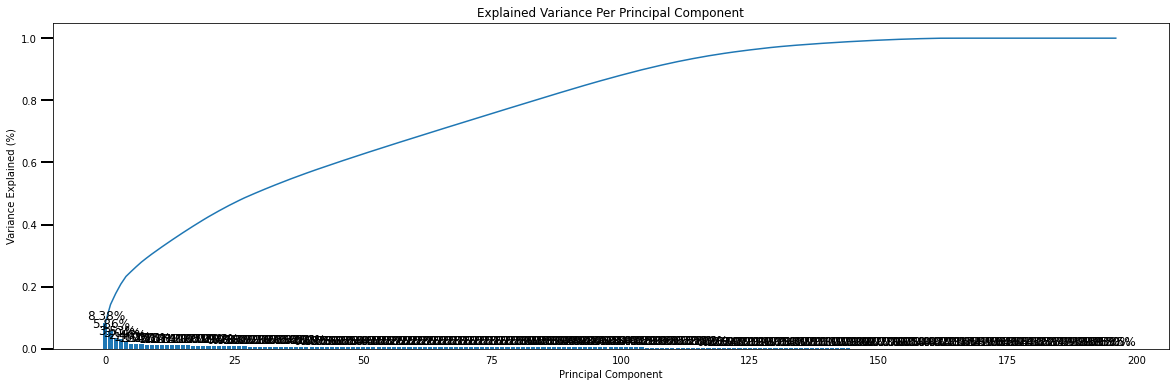

In [248]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_default)

# it is hard to see but it appears that ~%25 of the unexplained variance is 
#   from the first 5 (or so) principal components and ~50% from the first 27 (or so) 

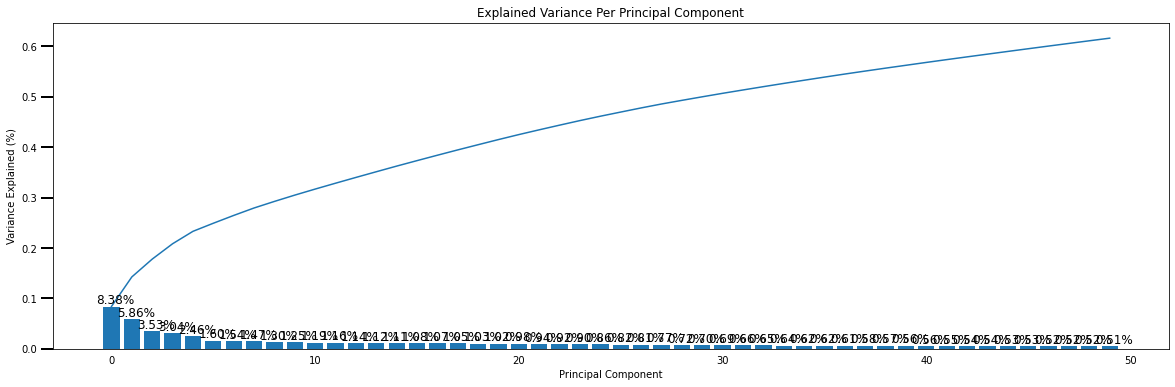

In [249]:
# Re-apply PCA to the data while selecting for number of components to retain.
# lets try n_componets = 50

pca_50   = PCA(n_components=50)
X_pca_50 = pca_50.fit_transform(azdias_clean_scaled)
scree_plot(pca_50)

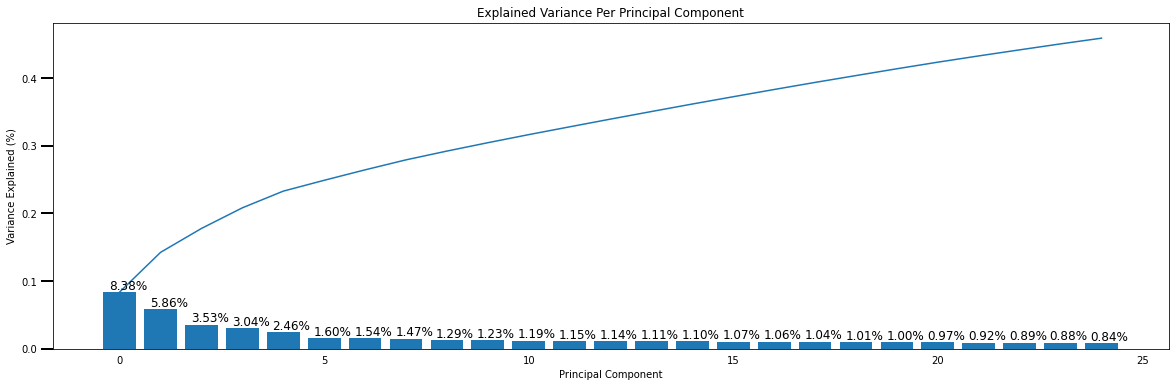

In [250]:
# Re-apply PCA to the data while selecting for number of components to retain.
# lets try n_componets = 25

pca_25   = PCA(n_components=25)
X_pca_25 = pca_25.fit_transform(azdias_clean_scaled)
scree_plot(pca_25)

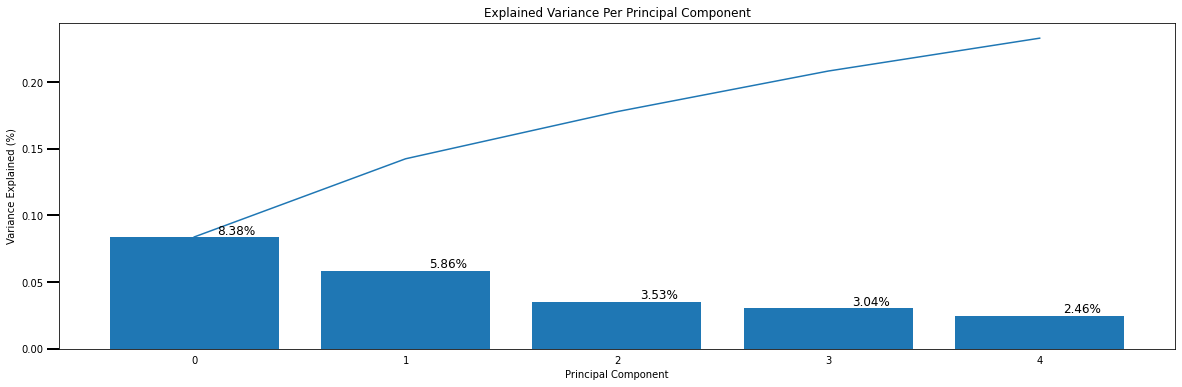

In [251]:
# Re-apply PCA to the data while selecting for number of components to retain.
# lets try n_componets = 5

pca_5   = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(azdias_clean_scaled)
scree_plot(pca_5)

In [135]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

### Discussion 2.2: Perform Dimensionality Reduction

>The scree plot appears to have a slight elbow at 5.<br><br>
>With 5 components, the cumulative explained variance is around 25%. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [252]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Lets build a DataFrame with weights from the 5 components mapped to the feature names
pca_n_components = pca_5.n_components_
pca_weight_df = pd.DataFrame(index=azdias_clean_features)

for component in range(pca_n_components):
    weight_label = 'PCA_Comp_Weight_'+str(component)
    pca_weight_df[weight_label] = pca_5.components_[component]

pca_weight_df.head()

,PCA_Comp_Weight_0,PCA_Comp_Weight_1,PCA_Comp_Weight_2,PCA_Comp_Weight_3,PCA_Comp_Weight_4
ALTERSKATEGORIE_GROB,-0.077986,0.238534,0.022067,-0.007074,0.049334
ANREDE_KZ,0.009340,0.039891,-0.334865,0.108139,-0.054189
FINANZ_MINIMALIST,-0.179256,0.095334,0.132096,-0.018327,0.017562
FINANZ_SPARER,0.101617,-0.229678,-0.054117,0.005057,-0.024807
FINANZ_VORSORGER,-0.076069,0.217135,0.048499,-0.001963,0.026816


In [200]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weigh

pca_weight_df.iloc[(-pca_weight_df['PCA_Comp_Weight_0'].abs()).argsort()]['PCA_Comp_Weight_0'][:10]

# MOBI_REGIO               -0.200374     - Movement Patterns (hi<->lo)              
# KBA05_ANTG1              -0.187419     - % 1-2 family houses in microcell (lo<->hi)
# ['LP_STATUS_GROB']_1.0    0.187055     + Social Status 1: low_income (no, yes)  
# FINANZ_MINIMALIST        -0.179256     - Financial Topology: low financial interest (poor?) (hi<->lo)
# PLZ8_ANTG1               -0.179126     - # 1-2 family houses in PLZ8 (lo<->hi)
# HH_EINKOMMEN_SCORE        0.178060     + Estimated household net income (hi<->lo)
# KBA05_GBZ                -0.177898     - # Buildings in microcell (lo<->hi)
# PLZ8_ANTG3                0.177595     + % 6-10 family houses in PLZ8 (lo<->hi)
# PLZ8_ANTG4                0.172576     + % 10+ family houses in PLZ8 (lo<->hi)
# CAMEO_INTL_2015_wealth    0.171913     + Wealth / Life Stage (hi<->lo)

# The top 10 contributors for principal component 1 involve financial status (being poor) 
#   and features that correlate with it such as number of persons living in the house.
# Note: I am intepretting 1-2, 6-10, 10+, etc. family houses as equating to the number 
#   of people, or families in a house. 

# Negative weights that are strongly correlated
#     Movement Patterns: movement patterns (high) 
#     Housing Demographics: %/# 1-2 homes (low), # buildings (low),   
#     Financial Typology: low financial interest (high)

# Positive weights that are stongly correlated with one another
#     Financial Status: Social Status=low income, Estimated household income (low), Wealth (low)
#     Housing Demographics: high % 6-10 and 10+ homes

# Principal component 0 seems to be driven by financial status.    
# It seems to correlate low income with higher numbers of people, or families, per house.
# Being poor drives causes the weights to be more negative and vice versa. 

# If we multiply the weight with the feature and the result is positive, this suggests low income.

MOBI_REGIO               -0.200374
KBA05_ANTG1              -0.187419
['LP_STATUS_GROB']_1.0    0.187055
FINANZ_MINIMALIST        -0.179256
PLZ8_ANTG1               -0.179126
HH_EINKOMMEN_SCORE        0.178060
KBA05_GBZ                -0.177898
PLZ8_ANTG3                0.177595
PLZ8_ANTG4                0.172576
CAMEO_INTL_2015_wealth    0.171913
Name: PCA_Comp_Weight_0, dtype: float64

In [205]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_df.iloc[(-pca_weight_df['PCA_Comp_Weight_1'].abs()).argsort()]['PCA_Comp_Weight_1'][:10]

# PRAEGENDE_JUGENDJAHRE_decade   -0.239169     - Decade of birth (lo(old)<->high(young))
# ALTERSKATEGORIE_GROB            0.238534     + Estimated Age (lo(young)<->hi(old))
# FINANZ_SPARER                  -0.229678     - Financial Typology: money-sparer (hi<->lo)
# SEMIO_REL                      -0.223413     - Personality: religious (hi<->lo)
# FINANZ_VORSORGER                0.217135     + Financial Typology: be prepared (hi<->lo)
# SEMIO_PFLICHT                  -0.213261     - Personality: dutiful (hi<->lo)
# FINANZ_UNAUFFAELLIGER          -0.212554     - Financial Typology: inconspicuous (hi<->lo)
# SEMIO_TRADV                    -0.211413     - Personality: traditional-minded (hi<->lo)
# FINANZ_ANLEGER                 -0.203130     - Financial Typology: investor (hi<->lo)
# ['ZABEOTYP']_3                  0.199177     + Energy consumption typology: fair supplied

# The top 10 contributors to principal component 2 all deal with age, personality type, and financial habits. 

# Negative weights that are strongly correlated
#     Decade of birth (old age)
#     Financial Tyopology: money-sparer (high), inconspicuous (high), investor (high)
#     Personality Traits: religious (high), dutiful (high), traditional-minded (high) 

# Positive weights that are stongly correlated with one another
#     Estimated Age (old age)
#     Financial Habits: be prepared (high)

# Principal component 1 seems to be driven by age and conservatism. (religious, dutiful, 
#   traditional-minded, money saving, investing, spending inconspicuous etc.)
# Being older and more conservative drives it up.  

# If we multiply the weight with the feature and the result is positive, this suggests being old and conservative. 

PRAEGENDE_JUGENDJAHRE_decade   -0.239169
ALTERSKATEGORIE_GROB            0.238534
FINANZ_SPARER                  -0.229678
SEMIO_REL                      -0.223413
FINANZ_VORSORGER                0.217135
SEMIO_PFLICHT                  -0.213261
FINANZ_UNAUFFAELLIGER          -0.212554
SEMIO_TRADV                    -0.211413
FINANZ_ANLEGER                 -0.203130
['ZABEOTYP']_3                  0.199177
Name: PCA_Comp_Weight_1, dtype: float64

In [202]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_df.iloc[(-pca_weight_df['PCA_Comp_Weight_2'].abs()).argsort()]['PCA_Comp_Weight_2'][:10]

# ANREDE_KZ        -0.334867     - Gender (male, female)
# SEMIO_VERT        0.314468     + Personality: dreamful (hi<->lo)
# SEMIO_KAEM       -0.302698     - Personality: combative attitide (hi<->lo)
# SEMIO_DOM        -0.268440     - Personality: dominant-minded (hi<->lo)
# SEMIO_KRIT       -0.257040     - Personality: critical-minded (hi<->lo)
# SEMIO_SOZ         0.251856     + Personality: socially-minded (hi<->lo)
# SEMIO_FAM         0.251179     + Personality: family-minded (hi<->lo)
# SEMIO_KULT        0.239557     + Personality: cultural-minded (hi<->lo)
# SEMIO_ERL        -0.196538     - Personality: event-oriented (hi<->lo)
# FINANZ_ANLEGER   -0.158612     - Financial Typology: investor (hi<->lo)

# Negative weights that are strongly correlated
#     Gender (Male) 
#     Personality Traits: combative(high), dominant-minded (high), critical-minded (high), & event-minded (high) 
#     Financial Habits: being an investor (high)

# Positive weights that are stongly correlated with one another
#     Personality Traits: dreamful (low), socially minded (low), family minded (low), culturally-minded (low)

# Clearly principal component 2 seems to be driven by gender and some specific characteristics.
# It seems to prefer aggressive, dominant males. 

# If we multiply the weight with the feature and the result is positive, this suggests bbeing an aggressive,
#   dominant male. 

ANREDE_KZ        -0.334867
SEMIO_VERT        0.314468
SEMIO_KAEM       -0.302698
SEMIO_DOM        -0.268440
SEMIO_KRIT       -0.257040
SEMIO_SOZ         0.251856
SEMIO_FAM         0.251179
SEMIO_KULT        0.239557
SEMIO_ERL        -0.196538
FINANZ_ANLEGER   -0.158612
Name: PCA_Comp_Weight_2, dtype: float64

### Discussion 2.3: Interpret Principal Components

>Observations:
>>Principal Component 0 is most heavily influenced financial status, specifically poor or not poor. If we multiply the weight with the feature and the result is positive, this suggests low income.<br><br>
>>Principal Component 1 is most heavily influenced by age, specifically old or not, and characteristics associated with old age (conservative ideology). If we multiply the weight with the feature and the result is positive, this suggests being old and conservative. <br><br>
>>Principal Component 2 seens most heavily influenced by gender and personality traits associated with gender. If we multiply the weight with the feature and the result is positive, this suggests an aggressive, dominant male. <br><br>
>>Put together it appears that the most important groupings of features, in order of importance, involve income, age, and gender. <br><br>


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [255]:
# Over a number of different cluster counts...
min_clusters=2
max_clusters=30
centers = []
scores = []
 
for k in range(min_clusters, max_clusters):

    # run k-means clustering on the data and...
    kmeans_k = KMeans(k)
    model_k  = kmeans_k.fit(X_pca_5)
    # compute the average within-cluster distances.
    score_k  = np.abs(model_k.score(X_pca_5))
    centers.append(k)
    scores.append(score_k)

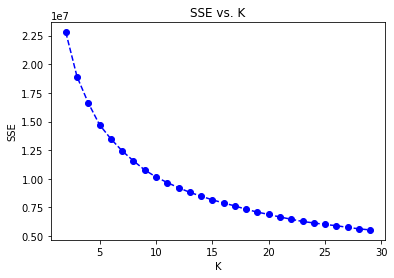

In [256]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#Your plot should look similar to the below
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 


In [258]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# From the scree plot above it looks like there there are several inflection points. 
# I am inclined to pick 10 clusters but I could have picked 5. I think I will pick the average (7). 

kmeans_8 = KMeans(8)
model_8  = kmeans_8.fit(X_pca_5)
labels_8 = model_8.predict(X_pca_5)

In [262]:
labels_8.shape

(684502,)

In [265]:
np.unique(labels_8)

array([0, 1, 2, 3, 4, 5, 6, 7])

Text(0, 0.5, 'Population Amount')

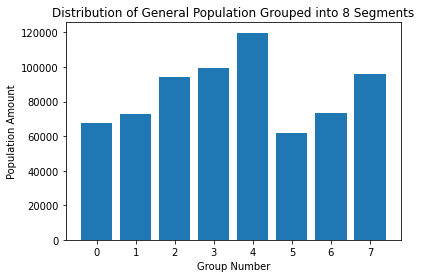

In [299]:
unique_elements, counts_elements = np.unique(labels_8, return_counts=True)
plt.bar(x=unique_elements, height=counts_elements,)
plt.title('Distribution of General Population Grouped into 8 Segments')
plt.xlabel('Group Number')
plt.ylabel('Population Amount')

### Discussion 3.1: Apply Clustering to General Population

>I ran several instances of KMeans on the reduced data set (X_pca_5) using a range of clusters (2-30).<br>
>The resulting scree plot of the scores looks like a negative exponential.<br>
>It looks like there could be inflection points at 5 and 10, so I chose a number between.<br>
>To do this, I visually, looked for the intersection of the line through points 2-4 and 15-20. The intersection is around 8.<br>

### Discussion: Overall Observations

> At this point, we have produced a new label for the general population data. This label is the result of clustering.<br><br>
>Steps:
>>1. Clean the data by removing columns and rows with too many NaNs in them<br>
>>2. Re-encoded certain features<br>
>>3. Replaced remaning NaNs
>>4. Performed PCA to reduce the number of features (columns) to 5
>>5. Performed KMeans to cluster the observations (rows) into 8 clusters 



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [302]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.shape

(191652, 85)

In [358]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Run the cleaning function
customers_clean = clean_data(customers)
customers_clean = clean_remaining_NaNs(customers_clean, feat_info)

# We need to make sure that customers_clean has the same columns as azdias_clean
# It is possible for customers_clean to have less columns than azdias_clean. 
# This is in fact the case. customers_clean does not have ['GEBAEUDETYP']_5.0 and
# it must be added with the value set to 0
customers_clean = add_remove_features(azdias_clean, customers_clean)

# Transform
customers_clean_transformed = transform_data(customers_clean)

# PCA it using pca_5. Do not re-fit. 
customers_clean_transformed_X_pca_5 = pca_5.transform(customers_clean_transformed)

# KMeans it using KMeans_8. Do not re-fit. 
customers_clean_labels_8 = model_8.predict(customers_clean_transformed_X_pca_5)

C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [359]:
diff = azdias_clean.shape[1] - customers_clean.shape[1]
print(diff)

0


In [360]:
print(customers_clean_labels_8.shape)
print(np.unique(customers_clean_labels_8))

(123748,)
[0 1 2 3 4 5 6 7]


Text(0, 0.5, 'Population Amount')

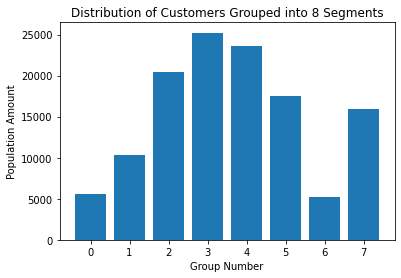

In [361]:
cc_unique_elements, cc_counts_elements = np.unique(customers_clean_labels_8, return_counts=True)
plt.bar(x=cc_unique_elements, height=cc_counts_elements,)
plt.title('Distribution of Customers Grouped into 8 Segments')
plt.xlabel('Group Number')
plt.ylabel('Population Amount')

In [308]:
def clean_remaining_NaNs(data_df, feature_df):
    """
    Address any remaining NaNs in data_df.
        
    INPUT:  Data DataFrame, Feature Information DataFrame
    OUTPUT: Data DataFrame modified by replacement of any remaining NaNs   
    """

    data      = data_df.copy()
    feat_info = feature_df.copy()

    # create a dictionary of columns with NaNs. The dictionary can be used for analysis. 
    remaining_NaN_cols  = {}
    remaining_feats_NaN = data.isna().any()[lambda x: x].index

    for col in remaining_feats_NaN:        
        remaining_NaN_cols[col] = data[col].isnull().sum()

    # turn the dictionary into a list
    remaining_missing_features = pd.DataFrame.from_dict(remaining_NaN_cols, orient='index')
    
    # add the type to remaining_missing_features 
    temp_rem_feat_view = feat_info.set_index('attribute')   
    for feature in remaining_missing_features.index:
        remaining_missing_features.at[feature, 'type'] = temp_rem_feat_view.loc[feature]['type'] 
    
    # set the mixed and ordinal NaNs to the median and the numeric NaNs to the mean.
    for feature in remaining_missing_features.index:
        if remaining_missing_features.loc[feature]['type'] == 'mixed':
            data[feature].fillna(value=data[feature].median(), inplace=True)
        elif remaining_missing_features.loc[feature]['type'] == 'ordinal':
            data[feature].fillna(value=data[feature].median(), inplace=True)
        elif remaining_missing_features.loc[feature]['type'] == 'numeric':
            data[feature].fillna(value=data[feature].mean(), inplace=True)
            
    return data

In [355]:
def add_remove_features(data_df1, data_df2):
    """
    Add or remove features from data_df2 so that it has the same columns as data_df1
    At this point, the functionality is limited to get the project to work. 
    It is only adding features to data_df2 and setting them to 0.
    The only use case are situations where one hot encoded features are missing from data_df2
    
    INPUT:  Data 1 DataFrame, Data 2 DataFrame
    OUTPUT: Data DataFrams with feature columns added or removed
    """
    
    data_orig   = data_df1.copy()
    data_target = data_df2.copy()
    difference  = data_orig.shape[1] - data_target.shape[1]
    
    # if the shape is the same, we will assume the columns are the same
    if difference == 0:
        return data_target
    
    # for this next code, we assume that df_2 does not have as many cols as data_df1
    # we also assume that there is just one column missing number is 1
    
    # identify the missing column
    set_diff = np.setdiff1d(list(azdias_clean.columns),(customers_clean.columns))
    col_to_add = set_diff[0]
    
    # get its position in the original data
    data_orig_cols = data_orig.columns.tolist()
    index = data_orig_cols.index(col_to_add)
    
    # insert it. since this is a categorical value, we can set it to 0
    data_target.insert(index,col_to_add,0)
    
    return data_target  

In [304]:
def transform_data(data_df):
    """
    Apply a StandardScaler to all columns (features) in data_df
        
    INPUT:  Data DataFrame
    OUTPUT: Data DataFrame with StandardScaler applied to all columns   
    """
    
    data = data_df.copy()
    
    # use ColumnTransformer to transform the data 
    data_features = data.columns
    ct = ColumnTransformer([('data_transformed', StandardScaler(), data_features)], remainder='passthrough')
    data_transform = ct.fit_transform(data)

    # reassemble the DataFrame
    data_scaled = pd.DataFrame(data_transform, columns=data_features)
    
    return data_scaled

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

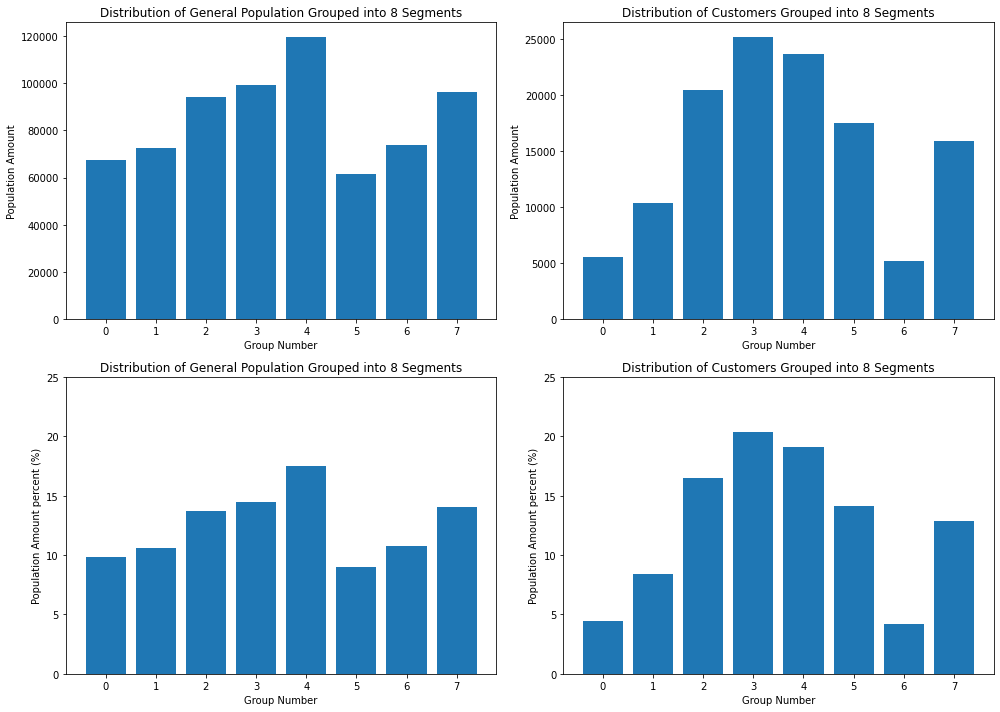

In [374]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

f, axes = plt.subplots(2,2,figsize=(14,10))
    
axes[0,0].bar(x=unique_elements, height=counts_elements,)
axes[0,0].set_title('Distribution of General Population Grouped into 8 Segments')
axes[0,0].set_xlabel('Group Number')
axes[0,0].set_ylabel('Population Amount')
    
axes[0,1].bar(x=cc_unique_elements, height=cc_counts_elements,)
axes[0,1].set_title('Distribution of Customers Grouped into 8 Segments')
axes[0,1].set_xlabel('Group Number')
axes[0,1].set_ylabel('Population Amount')
 
axes[1,0].bar(x=unique_elements, height=100*counts_elements/counts_elements.sum(),)
axes[1,0].set_title('Distribution of General Population Grouped into 8 Segments')
axes[1,0].set_xlabel('Group Number')
axes[1,0].set_ylabel('Population Amount percent (%)')
axes[1,0].set_ylim(bottom=0, top=25)
    
axes[1,1].bar(x=cc_unique_elements, height=100*cc_counts_elements/cc_counts_elements.sum(),)
axes[1,1].set_title('Distribution of Customers Grouped into 8 Segments')
axes[1,1].set_xlabel('Group Number')
axes[1,1].set_ylabel('Population Amount percent (%)')
axes[1,1].set_ylim(bottom=0, top=25)

plt.tight_layout()

In [390]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# the formula is (customer data - demographic data)
# positive numbers imply over representation of the customer data and is what we are targetting. 
# negative numbers imply under representation of the customer data and is not what we want to target. 

cluster_differences = 100*(cc_counts_elements/cc_counts_elements.sum() - counts_elements/counts_elements.sum())
cluster_diff_df = pd.Series(cluster_differences, index=unique_elements)
cluster_diff_df

0   -5.400341
1   -2.246492
2    2.797903
3    5.884265
4    1.582850
5    5.165925
6   -6.576739
7   -1.207371
dtype: float64

In [392]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# These are the positive numbers
# Groups 3 and 5. We want to target these

# Let's look at feature importance of both

model_8.cluster_centers_

# Group 3 has strong centers for PCAs 0 (negative) and 3 (positive)
# Group 5 has strong centers for PCA 1 (negative)

# From the PCA component alalysis, 
#   Principal Component 0     is most heavily influenced financial status, specifically poor or not poor.
#                             A positive number indicates low income. For Group 3, the number is negative which 
#                                suggests we are looking for people with high income.
#
#   Principal Component 1     is most heavily influenced by being old an conservative. 
#                             A positive number indicates being older and more conservative. For Group 5, the
#                                number is positive which suggests we are looking for older, more conservative people. 
#                       
#   Principal Component 3     seems most heavily influenced by family status and living arrangements. 
#                             A positive number indicates being a single, Green party supporting urbanite without
#                                much income and living with many. For Group 3, this suggests we are looking for
#                                an urbanite (city dweller. 
#
# Overall, this data suggests we need to target young urbanites and old conservatives.  


array([[ 4.54997404, -3.03475189,  2.69359131, -0.75627934,  0.06889883],
       [-1.28781637, -3.5952642 , -3.03004975, -0.07645488, -0.58997335],
       [ 2.6638536 ,  2.5152163 ,  2.65830299, -0.44838355,  0.5931162 ],
       [-4.57656607,  1.10457615,  1.1062396 ,  2.4952446 , -1.8754625 ],
       [-3.72326836,  1.4025846 , -0.79208302, -2.15329774,  1.27210667],
       [-2.8055358 , -4.39183146,  2.14248896, -0.6971414 ,  0.48666626],
       [ 5.0726807 , -2.42714262, -2.49478176,  1.18786006, -0.37720788],
       [ 2.44777995,  4.1769511 , -1.82025179,  0.67280758,  0.14481209]])

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Group 0 and 6. Don't target these. 

# Group 0 strong with PCA 0 (positive), PCA 1(negative), PCA 2 (positive)
# Group 6 strong with PCA 0 (positive), PCA 1(negative), PCA 2 (negative)

# From the PCA component alalysis, 
#   Principal Component 0     is most heavily influenced financial status, specifically poor or not poor.
#                             A positive number indicates low income. For Groups 0 and 6, the number is positive which 
#                                suggests we are NOT looking for people with low income.
#
#   Principal Component 1     is most heavily influenced by being old an conservative. 
#                             A positive number indicates being older and more conservative. For Groups 0 and 6, the
#                                number is negative which suggests we are not looking for younger, less conservative 
#                                people.
#
#   Principal Component 2     is most heavily influenced by gender and personality traits associated with it. 
#                             A positive number indicates aggress, dominant males. For Group 0, the number is 
#                                negative which suggests that we are not looking for aggressive males.
#                                For Group 6, the number is positive, indicating that we are not looking for 
#                                females. 
#
# Overall, the data suggests that we are not looking for low income, less conservative and younger males and females. 

In [384]:
# Let's look at PCA 3

pca_weight_df.iloc[(-pca_weight_df['PCA_Comp_Weight_3'].abs()).argsort()]['PCA_Comp_Weight_3'][:10]

# LP_LEBENSPHASE_GROB               0.240209     + *Life Stage (these are interleaved)
# ['LP_FAMILIE_GROB']_1.0          -0.237066     - # number of people in family (single)
# ['LP_FAMILIE_FEIN']_1.0          -0.237066     - Family status( single)
# LP_LEBENSPHASE_FEIN               0.236815     + life stage (~young_single_poor<->old_family_wealthy)
# ANZ_PERSONEN                      0.214484     + # adults in the house (lo<->hi)
# ['LP_FAMILIE_GROB']_5.0           0.210073     + # number of people in family (9-11)
# GREEN_AVANTGARDE                  0.186891     + Member in Green Party (no<->yes)
# PRAEGENDE_JUGENDJAHRE_movement    0.184330     + *Youth Politics (these are interleaved)
# ORTSGR_KLS9                       0.183431     + Size of community (lo<->hi)
# EWDICHTE                          0.182346     + Household Density in Community (lo<->hi)

# Negative weights that are strongly correlated
#     Being single

# Positive weights that are stongly correlated with one another
#     Lots of people in the famnily??, dense, urban, big family, lots of adults, being in the green party

# This one is harder to evaluate for a few reasons;
#   1) two of the features LP_LEBENSPHASE_GROB and PRAEGENDE_JUGENDJAHRE_movement do not have an 
#         value range that is inteprettable (e.g., lo to hi). The values are interleaved.  

# The data seems to suggest single, urbanites who do not make a lot of money, who have big families
#     (or live with many adults), and who are associated with the Green movement drives the values up.
#     Sounds like young libertals in urban centers.

# If we multiply the weight with the feature and the result is positive, this suggests being a single,  
#    urbanite who doesn't have a lot of income and who supports the Green party and likely lives 
#    with many others. 

LP_LEBENSPHASE_GROB               0.240209
['LP_FAMILIE_GROB']_1.0          -0.237066
['LP_FAMILIE_FEIN']_1.0          -0.237066
LP_LEBENSPHASE_FEIN               0.236815
ANZ_PERSONEN                      0.214484
['LP_FAMILIE_GROB']_5.0           0.210073
GREEN_AVANTGARDE                  0.186891
PRAEGENDE_JUGENDJAHRE_movement    0.184330
ORTSGR_KLS9                       0.183431
EWDICHTE                          0.182346
Name: PCA_Comp_Weight_3, dtype: float64

In [391]:
# Let's look at PCA 4

pca_weight_df.iloc[(-pca_weight_df['PCA_Comp_Weight_4'].abs()).argsort()]['PCA_Comp_Weight_4'][:10]

# LP_LEBENSPHASE_GROB               0.226376     + *Life Stage (these are interleaved)
# GREEN_AVANTGARDE                 -0.226072     - Member in Green Party (no<->yes)
# PRAEGENDE_JUGENDJAHRE_movement   -0.221900     - *Youth Politics (these are interleaved)
# ['LP_FAMILIE_FEIN']_1.0          -0.219709     - Family status(single)
# ['LP_FAMILIE_GROB']_1.0          -0.219709     - # number of people in family (single)
# LP_LEBENSPHASE_FEIN               0.213199     + life stage (~young_single_poor<->old_family_wealthy)
# ['LP_FAMILIE_GROB']_5.0           0.209018     + # number of people in family (9-11)
# KKK                               0.195586     + purchasing power (hi<->lo)
# ANZ_PERSONEN                      0.193866     + # adults in the house (lo<->hi)
# ['LP_STATUS_GROB']_5.0           -0.169741     - Socal Status (top income)

# Negative weights that are strongly correlated
#     Being in the Green Party, being single,low income

# Positive weights that are stongly correlated with one another
#     being (old, having a big family, and being wealthy)  

# This one is harder to evaluate for a few reasons;
#   1) two of the features LP_LEBENSPHASE_GROB and PRAEGENDE_JUGENDJAHRE_movement do not have an 
#         value range that is inteprettable (e.g., lo to hi). The values are interleaved.  

# If we multiply the weight with the feature and the result is positive, this suggests having a family and 
#   low income. 

LP_LEBENSPHASE_GROB               0.226376
GREEN_AVANTGARDE                 -0.226072
PRAEGENDE_JUGENDJAHRE_movement   -0.221900
['LP_FAMILIE_FEIN']_1.0          -0.219709
['LP_FAMILIE_GROB']_1.0          -0.219709
LP_LEBENSPHASE_FEIN               0.213199
['LP_FAMILIE_GROB']_5.0           0.209018
KKK                               0.195586
ANZ_PERSONEN                      0.193866
['LP_STATUS_GROB']_5.0           -0.169741
Name: PCA_Comp_Weight_4, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

>PCA Analysis
>>An analysis of the number of principal components for the cleaned azdias data indicated that there were 5 principal components.<br><br>
>>These five components seem to describe, in order of importance, income, age and conservatism, gender, living situation (e.g., single and urban), and one's family status (size and income). <br><br>
>>PCA components were analysed by identifying the top 10 contributing features to the component. Absolute values of the weights were sorted from high to low and the top ten taken for each PCA component.<br><br>
>>For each PCA component, the top weights were analyzed along with the range of values for the features. Since the features were normalized, we know that their ranges are negative to positive. We can then map the feature range to the product of the feature range and weight to determine what range of the feature makes the principal component more positive and more negative. This is very important to analyzing the meaning of the principal component.<br> <br>   
>> The first three components are more easily inteprettable than the last two. As a result, I wonder if I reduced the number features too much. <br><br>

>Clustering Analysis
>>The customer data was PCA'ed using the model from the azdias data.<br><br>
>>An analysis of the cluster sizes yielded a choice of 8 clusters. This number is somewhat arbritrary and the exercise could have been run with anywhere from 5-10 clusters.<br><br>
>>The percentages of each cluster for azdias and the customer data were compared to one another. Customer clusters that have a higher percentage than the azdias clusters indicate that these are the target audiences and vice versa.<br><br>
>>Specific customer clusters were chosen which overrepresent and underrepresent segmenta in the population (as described above).<br><br>
>>For each cluster, I looked for the largest principal component contributor(s), in terms of absolute value, and used it to make an inference on the type of person.<br><br>
>>The results were:<br>
>>>- The target population seems to be old and potentially young conservitives with disposable income.<br>
>>>- The population that should not be targetted are low income, less conservative, younger males and females.<br> 

>Last Thoughts:
>>If I were to make any updates to this analysis, I would first change the number of principal components and see if I can better intepret all of them.<br><br>
>>I could further attempt more feature engineering of the mixed data types. In particular, it might be useful to rearrange them into an ordered list. This may help me better intepret principal components 3 and 4.<br><br>